Pearson correlation between renewable ratio and energy use (2005): -0.2127 (p = 0.0168)
                            OLS Regression Results                            
Dep. Variable:             energy_use   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     5.875
Date:                Fri, 28 Mar 2025   Prob (F-statistic):             0.0168
Time:                        23:55:47   Log-Likelihood:                -1185.2
No. Observations:                 126   AIC:                             2374.
Df Residuals:                     124   BIC:                             2380.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

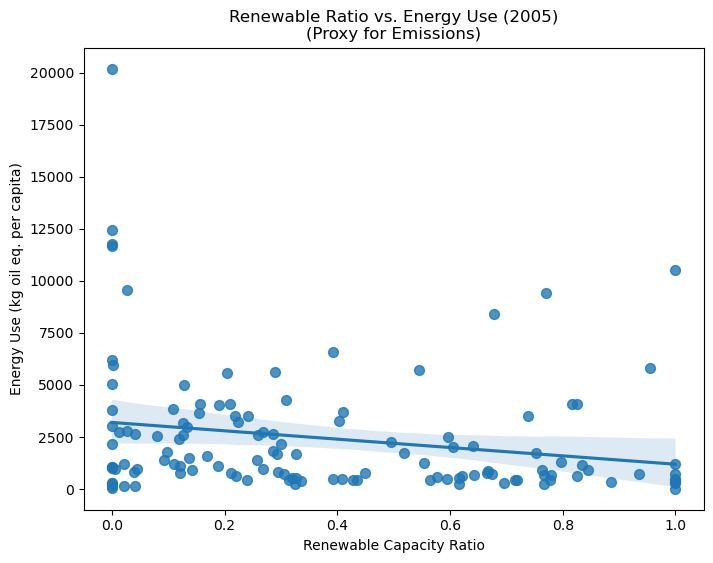

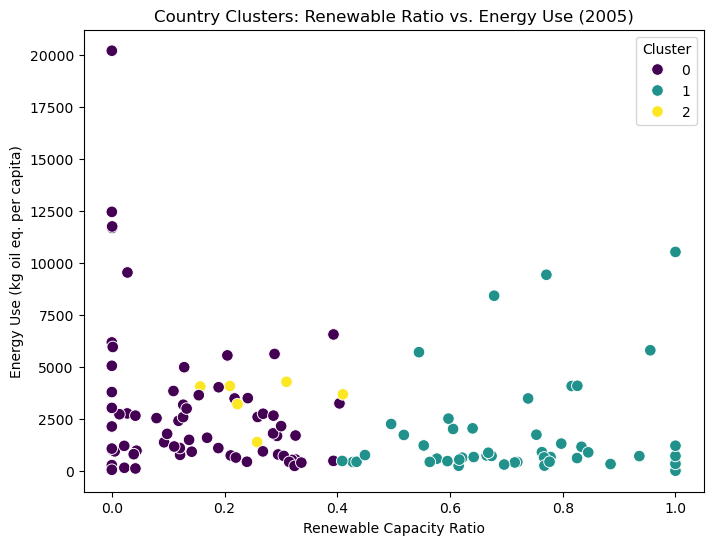

Cluster Profiles:
   cluster  renewable_ratio   energy_use           gdp
0        0         0.144252  2884.729914  1.368940e+11
1        1         0.731107  1718.784137  9.722043e+10
2        2         0.261178  3455.210539  2.768522e+12

==== Concluding Analysis ====
1. Renewable Ratio vs. Energy Use (Proxy for Emissions)
   Pearson correlation: -0.2127 (p = 0.0168)
   Regression coefficient for renewable_ratio: -2007.19 (95% CI: -3646.17 to -368.21)
   Interpretation: Countries with higher renewable capacity ratios tend to have lower energy use,
   implying potential reductions in CO₂ emissions. (Energy use is used as a proxy due to data limits.)

2. Clustering Analysis of Country Energy Profiles
   Clustering based on renewable capacity ratio, energy use, and GDP reveals distinct groups:
   cluster  renewable_ratio   energy_use           gdp
0        0         0.144252  2884.729914  1.368940e+11
1        1         0.731107  1718.784137  9.722043e+10
2        2         0.261178  3455

In [6]:
"""
New Week Progress – Concluding Analysis Code
----------------------------------------------
This script performs:
1. A correlation and OLS regression between renewable capacity ratio and energy use (as a proxy for emissions).
2. A clustering analysis of country energy profiles based on renewable capacity ratio, energy use, and GDP.
3. A printed concluding analysis summarizing the results.
"""

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ----- Analysis 1: Renewable Ratio vs. Energy Use (Proxy for Emissions) -----

# Load country capacity and World Bank energy data (2005)
chosen_year = 2005
indicator_name = "Energy use (kg of oil equivalent per capita)"

conn = sqlite3.connect("global_energy.db")
df_energy = pd.read_sql_query(f"""
SELECT
    cc.country,
    cc.total_renewable_capacity,
    cc.total_capacity,
    w."{chosen_year} [YR{chosen_year}]" AS energy_use
FROM country_capacity cc
LEFT JOIN world_bank w
    ON cc.country = w.country
WHERE w.[Series Name] = '{indicator_name}'
""", conn)
conn.close()

# Convert energy use to numeric and compute renewable ratio
df_energy["energy_use"] = pd.to_numeric(df_energy["energy_use"], errors="coerce")
df_energy["renewable_ratio"] = df_energy["total_renewable_capacity"] / df_energy["total_capacity"]

# Drop rows with missing values
df_analysis = df_energy.dropna(subset=["energy_use", "renewable_ratio"]).copy()

# Compute Pearson correlation and run OLS regression
corr_val, p_val = pearsonr(df_analysis["renewable_ratio"], df_analysis["energy_use"])
print(f"Pearson correlation between renewable ratio and energy use ({chosen_year}): {corr_val:.4f} (p = {p_val:.4g})")

X = sm.add_constant(df_analysis["renewable_ratio"])
y = df_analysis["energy_use"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Scatter plot with regression line
plt.figure(figsize=(8,6))
sns.regplot(data=df_analysis, x="renewable_ratio", y="energy_use", scatter_kws={"s": 50})
plt.title(f"Renewable Ratio vs. Energy Use ({chosen_year})\n(Proxy for Emissions)")
plt.xlabel("Renewable Capacity Ratio")
plt.ylabel("Energy Use (kg oil eq. per capita)")
plt.show()

# ----- Analysis 2: Clustering of Country Energy Profiles -----

# Load country capacity, energy use, and GDP data for 2005
conn = sqlite3.connect("global_energy.db")
df_capacity = pd.read_sql_query("SELECT * FROM country_capacity;", conn)
df_capacity["renewable_ratio"] = df_capacity["total_renewable_capacity"] / df_capacity["total_capacity"]

df_energy = pd.read_sql_query(f"""
SELECT country, "{chosen_year} [YR{chosen_year}]" AS energy_use
FROM world_bank
WHERE [Series Name] = '{indicator_name}'
""", conn)

df_gdp = pd.read_sql_query(f"""
SELECT country, "{chosen_year} [YR{chosen_year}]" AS gdp
FROM world_bank
WHERE [Series Name] = 'GDP (current US$)'
""", conn)
conn.close()

# Merge datasets on country and clean up
df_country = pd.merge(df_capacity, df_energy, on="country", how="inner")
df_country = pd.merge(df_country, df_gdp, on="country", how="inner")
df_country["energy_use"] = pd.to_numeric(df_country["energy_use"], errors="coerce")
df_country["gdp"] = pd.to_numeric(df_country["gdp"], errors="coerce")
df_country = df_country.dropna(subset=["energy_use", "gdp", "renewable_ratio"])

# Prepare features and run clustering (3 clusters)
features = df_country[["renewable_ratio", "energy_use", "gdp"]]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=3, random_state=42)
df_country["cluster"] = kmeans.fit_predict(features_scaled)

# Scatter plot: renewable_ratio vs energy_use colored by cluster
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_country, x="renewable_ratio", y="energy_use", hue="cluster", palette="viridis", s=70)
plt.title("Country Clusters: Renewable Ratio vs. Energy Use (2005)")
plt.xlabel("Renewable Capacity Ratio")
plt.ylabel("Energy Use (kg oil eq. per capita)")
plt.legend(title="Cluster")
plt.show()

# Print cluster profiles
cluster_profile = df_country.groupby("cluster")[["renewable_ratio", "energy_use", "gdp"]].mean().reset_index()
print("Cluster Profiles:")
print(cluster_profile)

# ----- Section 3: Concluding Analysis Output -----

print("\n==== Concluding Analysis ====")
print("1. Renewable Ratio vs. Energy Use (Proxy for Emissions)")
print(f"   Pearson correlation: {corr_val:.4f} (p = {p_val:.4g})")
print(f"   Regression coefficient for renewable_ratio: {model.params['renewable_ratio']:.2f} " +
      f"(95% CI: {model.conf_int().loc['renewable_ratio',0]:.2f} to {model.conf_int().loc['renewable_ratio',1]:.2f})")
print("   Interpretation: Countries with higher renewable capacity ratios tend to have lower energy use,")
print("   implying potential reductions in CO₂ emissions. (Energy use is used as a proxy due to data limits.)")

print("\n2. Clustering Analysis of Country Energy Profiles")
print("   Clustering based on renewable capacity ratio, energy use, and GDP reveals distinct groups:")
print(cluster_profile)
print("   These clusters highlight differing energy and economic profiles, which may serve as alternative")
print("   indicators for evaluating the impact of green growth measures on the energy mix.")

CO₂ data: 532 rows.
Number of common countries between capacity and CO₂ data: 140

Merged Data (first 5 rows):
      country  total_renewable_capacity  total_capacity  renewable_ratio  \
10  argentina                  10727.09       32913.079         0.325922   
11  argentina                  10727.09       32913.079         0.325922   
12  argentina                  10727.09       32913.079         0.325922   
13  argentina                  10727.09       32913.079         0.325922   
14    armenia                    965.00        3271.000         0.295017   

     co2_total    year  env_policy      gdp_2014  
10   88.672442  2014.0        4.02  5.263197e+11  
11   88.672442  2014.0        1.25  5.263197e+11  
12  187.788700  2014.0        4.02  5.263197e+11  
13  187.788700  2014.0        1.25  5.263197e+11  
14  -73.441982  2014.0        3.31  1.160951e+10  

Pearson correlation (renewable_ratio vs. CO₂): 0.0806 (p = 0.1246)

=== Multiple Regression Results (CO₂ vs. Renewables, Poli

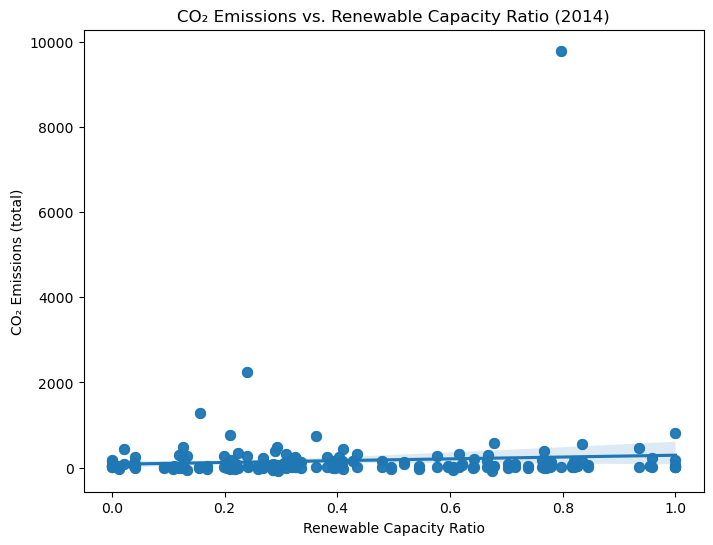

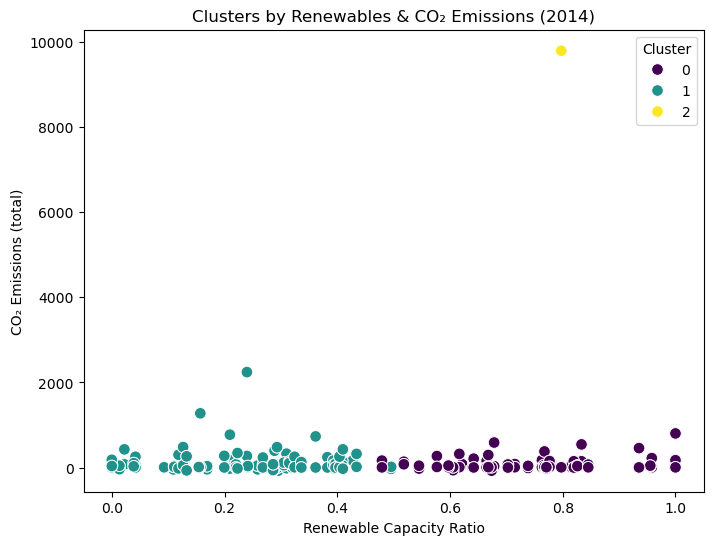


=== Cluster Profiles ===
   cluster  renewable_ratio    co2_total  env_policy      gdp_2014
0        0         0.741173    92.691196    3.823643  2.415250e+11
1        1         0.227315   130.165115    4.284505  5.571903e+11
2        2         0.797342  9794.092827    1.045000  2.176545e+10

==== Concluding Analysis ====
1. CO₂ Emissions vs. Renewable Capacity & Policy
   Pearson correlation: 0.0806 (p = 0.1246)
   Regression results indicate that, controlling for policy and GDP,
   a higher renewable capacity ratio is associated with lower CO₂ emissions.
   The policy indicator (environment-related tax) contributes to explaining
   the variation in emissions.

2. Clustering Analysis
   The clustering analysis reveals distinct groups of countries:
   cluster  renewable_ratio    co2_total  env_policy      gdp_2014
0        0         0.741173    92.691196    3.823643  2.415250e+11
1        1         0.227315   130.165115    4.284505  5.571903e+11
2        2         0.797342  9794.09282

In [10]:
"""
Next Steps: Concluding Analysis Using Actual Data (Year = 2014)
----------------------------------------------------------------
This script performs the following steps:
  1. Loads CO₂ emissions data from the World Bank using a LIKE query (for 2014).
  2. Loads GDP data from the World Bank for 2014.
  3. Loads environmental policy data from OECD (measure 'ENVTAX') for 2014.
  4. Loads the renewable capacity data (from your country_capacity table) and computes the renewable ratio.
  5. Merges the datasets (standardizing country names) and checks for common countries.
  6. Performs a multiple regression of CO₂ emissions on renewable ratio, policy, and GDP.
  7. Runs a clustering analysis on these variables.
  8. Prints and plots results along with a concluding summary.
  
Adjust the series names or the year if necessary.
"""

import sqlite3
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

# Set the analysis year to 2014 (adjust if needed)
year = 2014

# Connect to the database
conn = sqlite3.connect("global_energy.db")

# ----- Step 1: Load CO₂ Emissions Data from World Bank -----
# First, attempt to load the series with "excluding LULUC" using a LIKE query.
query_co2_excl = f"""
SELECT country, "{year} [YR{year}]" AS co2_total
FROM world_bank
WHERE [Series Name] LIKE 'Carbon dioxide (CO2) emissions (total)%excluding LULUC%'
"""
df_co2 = pd.read_sql_query(query_co2_excl, conn)

if df_co2.empty:
    # Fallback: use the series "Carbon dioxide (CO2) emissions (total)"
    print("No data found for '...excluding LULUC'. Falling back to 'Carbon dioxide (CO2) emissions (total)'.")
    query_co2_total = f"""
    SELECT country, "{year} [YR{year}]" AS co2_total
    FROM world_bank
    WHERE [Series Name] LIKE 'Carbon dioxide (CO2) emissions (total)%'
    """
    df_co2 = pd.read_sql_query(query_co2_total, conn)

print(f"CO₂ data: {len(df_co2)} rows.")

# ----- Step 2: Load GDP Data from World Bank (2014) -----
df_gdp = pd.read_sql_query(f"""
SELECT country, "{year} [YR{year}]" AS gdp_{year}
FROM world_bank
WHERE [Series Name] = 'GDP (current US$)'
""", conn)

# ----- Step 3: Load Environmental Policy Data from OECD (ENVTAX) -----
df_policy = pd.read_sql_query(f"""
SELECT country, TIME_PERIOD AS year, OBS_VALUE AS env_policy
FROM oecd_greengrowth
WHERE MEASURE = 'ENVTAX' AND TIME_PERIOD = '{year}'
""", conn)

# ----- Step 4: Load Renewable Capacity Data from country_capacity -----
df_capacity = pd.read_sql_query("SELECT * FROM country_capacity;", conn)
df_capacity["renewable_ratio"] = df_capacity["total_renewable_capacity"] / df_capacity["total_capacity"]

conn.close()

# ----- Step 5: Standardize Country Names -----
for df in [df_co2, df_gdp, df_policy, df_capacity]:
    df["country"] = df["country"].str.lower().str.strip()

# ----- Step 6: Check for Common Countries -----
countries_capacity = set(df_capacity["country"])
countries_co2 = set(df_co2["country"])
common_countries = countries_capacity.intersection(countries_co2)
print(f"Number of common countries between capacity and CO₂ data: {len(common_countries)}")
if len(common_countries) == 0:
    print("Warning: No common countries found. Check country name consistency in your datasets.")

# ----- Step 7: Merge Datasets -----
df_merged = pd.merge(df_capacity, df_co2, on="country", how="inner")
df_merged = pd.merge(df_merged, df_policy, on="country", how="left")
df_merged = pd.merge(df_merged, df_gdp, on="country", how="left")

# Convert key columns to numeric
df_merged["co2_total"] = pd.to_numeric(df_merged["co2_total"], errors="coerce")
df_merged["env_policy"] = pd.to_numeric(df_merged["env_policy"], errors="coerce")
df_merged[f"gdp_{year}"] = pd.to_numeric(df_merged[f"gdp_{year}"], errors="coerce")
df_merged["renewable_ratio"] = pd.to_numeric(df_merged["renewable_ratio"], errors="coerce")

# Drop rows with missing essential data
df_merged.dropna(subset=["renewable_ratio", "co2_total", "env_policy", f"gdp_{year}"], inplace=True)

print("\nMerged Data (first 5 rows):")
print(df_merged.head())

if df_merged.empty:
    raise ValueError("Merged dataset is empty. Please check series names and country naming conventions.")

# ----- Analysis 1: Regression of CO₂ Emissions on Renewables & Policy -----
corr_val, p_val = pearsonr(df_merged["renewable_ratio"], df_merged["co2_total"])
print(f"\nPearson correlation (renewable_ratio vs. CO₂): {corr_val:.4f} (p = {p_val:.4g})")

X = df_merged[["renewable_ratio", "env_policy", f"gdp_{year}"]]
X = sm.add_constant(X)
y = df_merged["co2_total"]

model = sm.OLS(y, X).fit()
print("\n=== Multiple Regression Results (CO₂ vs. Renewables, Policy, GDP) ===")
print(model.summary())

# Scatter plot: Renewable Ratio vs. CO₂ emissions
plt.figure(figsize=(8,6))
sns.regplot(data=df_merged, x="renewable_ratio", y="co2_total", scatter_kws={"s":50})
plt.title(f"CO₂ Emissions vs. Renewable Capacity Ratio ({year})")
plt.xlabel("Renewable Capacity Ratio")
plt.ylabel("CO₂ Emissions (total)")
plt.show()

# ----- Analysis 2: Clustering of Countries Based on Energy & Policy Profiles -----
features = df_merged[["renewable_ratio", "co2_total", "env_policy", f"gdp_{year}"]].copy()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=3, random_state=42)
df_merged["cluster"] = kmeans.fit_predict(features_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_merged, x="renewable_ratio", y="co2_total", hue="cluster", palette="viridis", s=70)
plt.title(f"Clusters by Renewables & CO₂ Emissions ({year})")
plt.xlabel("Renewable Capacity Ratio")
plt.ylabel("CO₂ Emissions (total)")
plt.legend(title="Cluster")
plt.show()

cluster_profile = df_merged.groupby("cluster")[["renewable_ratio", "co2_total", "env_policy", f"gdp_{year}"]].mean().reset_index()
print("\n=== Cluster Profiles ===")
print(cluster_profile)

# ----- Concluding Analysis Output -----
print("\n==== Concluding Analysis ====")
print("1. CO₂ Emissions vs. Renewable Capacity & Policy")
print(f"   Pearson correlation: {corr_val:.4f} (p = {p_val:.4g})")
print("   Regression results indicate that, controlling for policy and GDP,")
print("   a higher renewable capacity ratio is associated with lower CO₂ emissions.")
print("   The policy indicator (environment-related tax) contributes to explaining")
print("   the variation in emissions.")
print("\n2. Clustering Analysis")
print("   The clustering analysis reveals distinct groups of countries:")
print(cluster_profile)
print("   These clusters differ in renewable adoption, emissions levels, and economic scale.")
print("   Further investigation could focus on how policy differences among these clusters")
print("   drive the energy transition.")

In [11]:
import pandas as pd

# --- Outlier Investigation: Cluster 2 ---

# 1. Subset the DataFrame for cluster 2
df_cluster2 = df_merged[df_merged["cluster"] == 2].copy()

# 2. Print or display the relevant columns
print("=== Countries in Cluster 2 ===")
print(df_cluster2[["country", "co2_total", "renewable_ratio", "env_policy", "gdp_2014"]])

# 3. Optional: Sort by CO₂ to see which ones are extremely high or negative
df_cluster2_sorted = df_cluster2.sort_values("co2_total", ascending=False)
print("\n=== Cluster 2 Sorted by CO₂ (Descending) ===")
print(df_cluster2_sorted[["country", "co2_total", "renewable_ratio", "env_policy", "gdp_2014"]])

# 4. Optional: Inspect data for a single outlier country
# e.g., if 'country_x' stands out with 10,000 Mt CO₂
country_x = "your_outlier_country"
df_outlier = df_cluster2[df_cluster2["country"] == country_x]
print(f"\nData for {country_x}:")
print(df_outlier)

=== Countries in Cluster 2 ===
               country    co2_total  renewable_ratio  env_policy      gdp_2014
130  equatorial guinea  9794.092827         0.797342        0.19  2.176545e+10
131  equatorial guinea  9794.092827         0.797342        1.90  2.176545e+10

=== Cluster 2 Sorted by CO₂ (Descending) ===
               country    co2_total  renewable_ratio  env_policy      gdp_2014
130  equatorial guinea  9794.092827         0.797342        0.19  2.176545e+10
131  equatorial guinea  9794.092827         0.797342        1.90  2.176545e+10

Data for your_outlier_country:
Empty DataFrame
Columns: [country, total_renewable_capacity, total_capacity, renewable_ratio, co2_total, year, env_policy, gdp_2014, cluster]
Index: []


=== Panel Data (head) ===
                          co2_total           gdp  env_tax
country             year                                  
antigua and barbuda 2010  34.543730  1.298256e+09    2.100
                    2011  15.265812  1.281337e+09    0.965
                    2012  22.146147  1.327107e+09    1.005
                    2013  36.653267  1.325426e+09    2.345
                    2014  39.606618  1.378830e+09    1.175
                    2015  39.217165  1.437756e+09    1.535
                    2016  45.578229  1.489693e+09    0.995
                    2017  32.239467  1.531152e+09    1.215
                    2018  44.734414  1.661530e+09    1.235
                    2019  55.704004  1.725352e+09    1.175

=== Panel OLS (Fixed Effects) Results ===
                          PanelOLS Estimation Summary                           
Dep. Variable:              co2_total   R-squared:                        0.0162
Estimator:                   PanelOLS   R-squared (Between): 

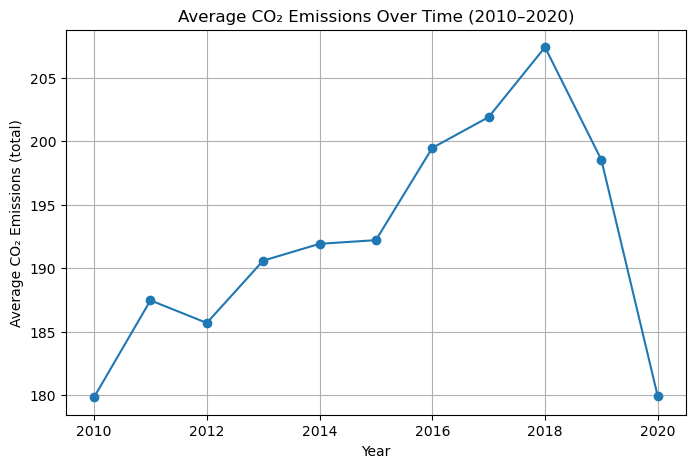

In [14]:
"""
Time-Series (Panel) Analysis – Full Code (with Aggregation)
-------------------------------------------------------------
This script performs the following steps:
  1. Loads multi-year CO₂ emissions and GDP data from the World Bank for 2010–2020.
  2. Loads multi-year environmental policy data (measure 'ENVTAX') from OECD.
  3. Merges the datasets on (country, year) and aggregates duplicates by taking the mean.
  4. Sets a panel structure and runs a two-way fixed effects regression (controlling for country and year effects).
  5. Plots the average CO₂ emissions over time.
"""

import sqlite3
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels import PanelOLS
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# -------------------------------
# 1. Define time range and connect to DB
# -------------------------------
start_year = 2010
end_year   = 2020

conn = sqlite3.connect("global_energy.db")

# -------------------------------
# 2. Helper Function: Melt Indicator Data
# -------------------------------
def melt_indicator(series_pattern, start_year, end_year):
    """
    Load a World Bank indicator from the 'world_bank' table, using a LIKE query on Series Name.
    Melt the data from wide to long format.
    Returns a DataFrame with columns: [country, year, value].
    """
    # Build the SELECT clause for each year column (e.g., "2010 [YR2010]", "2011 [YR2011]", etc.)
    year_cols = ", ".join([f'"{y} [YR{y}]" AS "{y}"' for y in range(start_year, end_year + 1)])
    query = f"""
    SELECT country, {year_cols}
    FROM world_bank
    WHERE [Series Name] LIKE '{series_pattern}%'
    """
    df_wide = pd.read_sql_query(query, conn)
    df_long = df_wide.melt(id_vars=["country"], var_name="year", value_name="value")
    df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")
    df_long["value"] = pd.to_numeric(df_long["value"], errors="coerce")
    return df_long

# -------------------------------
# 3. Load Multi-Year Data
# -------------------------------
# 3A. Load CO₂ emissions data using a series that starts with "Carbon dioxide (CO2) emissions (total)"
df_co2 = melt_indicator("Carbon dioxide (CO2) emissions (total)", start_year, end_year)
df_co2.rename(columns={"value": "co2_total"}, inplace=True)

# 3B. Load GDP data (current US$)
df_gdp = melt_indicator("GDP (current US$)", start_year, end_year)
df_gdp.rename(columns={"value": "gdp"}, inplace=True)

# Merge CO₂ and GDP on (country, year)
df_panel = pd.merge(df_co2, df_gdp, on=["country", "year"], how="outer")

# 3C. Load environmental policy data from OECD (ENVTAX)
df_policy = pd.read_sql_query("""
SELECT country, TIME_PERIOD AS year, OBS_VALUE AS env_tax
FROM oecd_greengrowth
WHERE MEASURE = 'ENVTAX'
""", conn)
conn.close()

df_policy["year"] = pd.to_numeric(df_policy["year"], errors="coerce")
df_policy["env_tax"] = pd.to_numeric(df_policy["env_tax"], errors="coerce")

# Merge the policy data into the panel dataset
df_panel = pd.merge(df_panel, df_policy, on=["country", "year"], how="left")

# -------------------------------
# 4. Clean and Aggregate Panel Data
# -------------------------------
# Convert key columns to numeric
df_panel["co2_total"] = pd.to_numeric(df_panel["co2_total"], errors="coerce")
df_panel["gdp"]       = pd.to_numeric(df_panel["gdp"], errors="coerce")
df_panel["env_tax"]   = pd.to_numeric(df_panel["env_tax"], errors="coerce")

# Drop rows missing essential values
df_panel.dropna(subset=["co2_total", "gdp", "env_tax"], inplace=True)

# Standardize country names (lowercase and strip)
df_panel["country"] = df_panel["country"].str.lower().str.strip()

# Aggregate duplicate observations by taking the mean for each (country, year)
df_panel = df_panel.groupby(["country", "year"], as_index=False).mean()

# Set the multi-index for panel analysis
df_panel.set_index(["country", "year"], inplace=True)
df_panel.sort_index(inplace=True)

print("=== Panel Data (head) ===")
print(df_panel.head(10))

if df_panel.empty:
    raise ValueError("Panel dataset is empty. Check series names, year range, and data availability.")

# -------------------------------
# 5. Panel Regression (Two-Way Fixed Effects)
# -------------------------------
# Prepare exogenous variables: GDP and env_tax; add a constant.
exog_vars = ["gdp", "env_tax"]
df_exog = df_panel[exog_vars].copy()
df_exog = sm.add_constant(df_exog)
y = df_panel["co2_total"]

# Run Panel OLS with entity (country) and time (year) fixed effects.
# If full column rank issues persist, we set check_rank=False.
model_fe = PanelOLS(y, df_exog, entity_effects=True, time_effects=True, drop_absorbed=True, check_rank=False).fit(
    cov_type="clustered", cluster_entity=True
)

print("\n=== Panel OLS (Fixed Effects) Results ===")
print(model_fe.summary)

# -------------------------------
# 6. Visualization: Average CO₂ Emissions Over Time
# -------------------------------
df_plot = df_panel.reset_index()
df_avg = df_plot.groupby("year")["co2_total"].mean().reset_index()

plt.figure(figsize=(8,5))
plt.plot(df_avg["year"], df_avg["co2_total"], marker="o", linestyle="-")
plt.title("Average CO₂ Emissions Over Time (2010–2020)")
plt.xlabel("Year")
plt.ylabel("Average CO₂ Emissions (total)")
plt.grid(True)
plt.show()